In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Introduction 
* American Sign Language (ASL) is a complete, natural language used by the Deaf community to communicate through hand gestures, finger movements, and facial expressions.
The purpose of ASL recognition is to automatically interpret these hand gestures using computer vision and machine learning, enabling real-time translation from signs to readable text or speech. This helps bridge communication gaps between Deaf and hearing individuals.
## Project Goal
* The main goal of this project is to build CNN model capable of classifying ASL hand gestures from images.
Depending on the dataset used, the model may classify:
  * ASL alphabet letters (A–Z)
* The project aims to develop an accurate and robust system that can identify these gestures from image data using deep learning.

## Dataset Overview

* The dataset consists of images of hands showing different ASL gestures. Key characteristics include:
  *  A set of labeled images, each corresponding to a specific ASL gesture
  * Variations in hand orientation, lighting, and background
  * Images stored in class-specific folders (one folder per ASL letter)


## Imports and environment setup

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image



## Data preprocessing and augmentation

In [5]:
TRAIN_DIR = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
TEST_DIR = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

In [6]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Setting up data generators...")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=False,  
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest',
    validation_split=0.2  
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Get class labels
class_labels = list(train_generator.class_indices.keys())
print(f"\nClasses: {class_labels}")
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")

Setting up data generators...
Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Number of training samples: 69600
Number of validation samples: 17400


## Model building (CNN Model)

In [ ]:
print("\nBuilding CNN model...")

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.6),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(29, activation='softmax')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 124, 124, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,415,613 (13.03 MB)

 Trainable params: 3,412,157 (13.02 MB)

 Non-trainable params: 3,456 (13.50 KB)

## Model training with callbacks

In [9]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_asl_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [12]:
print("\nTraining model...")

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1763405476.039834     117 service.cc:148] XLA service 0x7834880027c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763405476.040912     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763405477.082394     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2175 ━━━━━━━━━━━━━━━━━━━━ 12:10:22 20s/step - accuracy: 0.0625 - loss: 4.0578

I0000 00:00:1763405486.712492     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2619 - loss: 2.6292
Epoch 1: val_accuracy improved from -inf to 0.62052, saving model to best_asl_model.h5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 737s 330ms/step - accuracy: 0.2620 - loss: 2.6288 - val_accuracy: 0.6205 - val_loss: 1.2544 - learning_rate: 0.0010
Epoch 2/25
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7778 - loss: 0.6577
Epoch 2: val_accuracy did not improve from 0.62052
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 443s 204ms/step - accuracy: 0.7778 - loss: 0.6576 - val_accuracy: 0.5419 - val_loss: 1.5363 - learning_rate: 0.0010
Epoch 3/25
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8764 - loss: 0.3726
Epoch 3: val_accuracy improved from 0.62052 to 0.83707, saving model to best_asl_model.h5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 521s 239ms/step - accuracy: 0.8764 - loss: 0.3725 - val_accuracy: 0.8371 - val_loss: 0.6079 - learning_rate: 0.0010
Epoch 4/25
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.91

* We save the best model during the training that obtained from epoch 7 with  train_accuracy: 0.9545 - train_loss: 0.1416 & validation_accuracy:0.89207 - validation_loss:0.3304

## Model evaluation and performance metrics


Plotting training history...


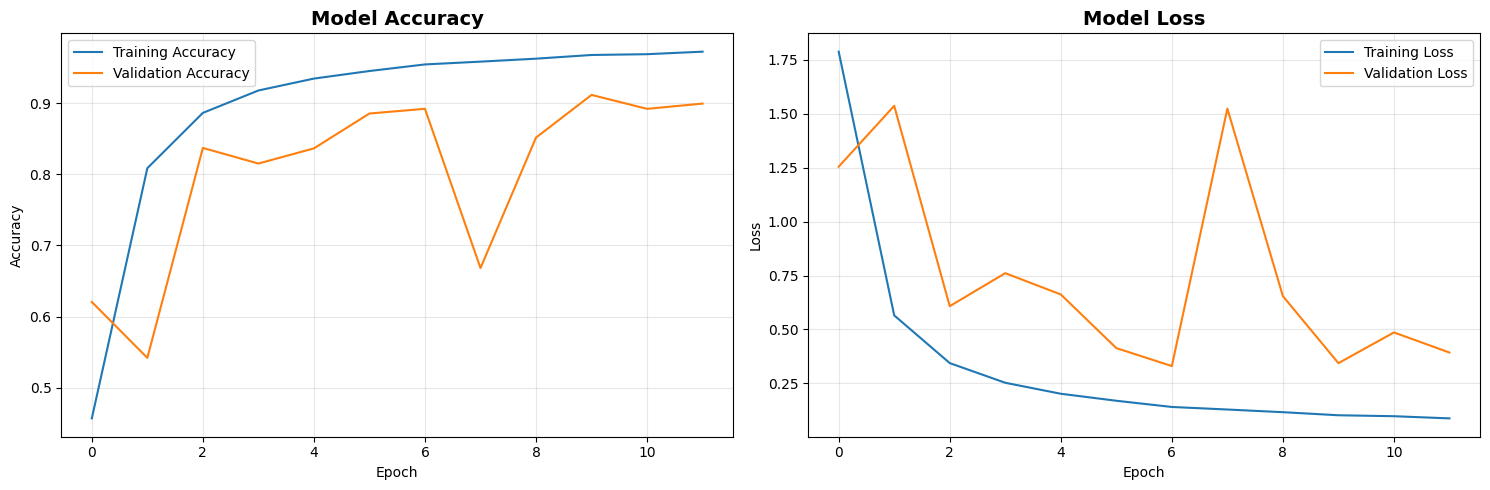

In [14]:
print("\nPlotting training history...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
print("\n" + "="*60)
print("EVALUATING MODEL ON VALIDATION DATA")
print("="*60)


# Ensure validation generator starts from beginning
validation_generator.reset()

val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")



EVALUATING MODEL ON VALIDATION DATA
544/544 ━━━━━━━━━━━━━━━━━━━━ 92s 169ms/step - accuracy: 0.9340 - loss: 0.2367

Validation Accuracy: 0.9082
Validation Loss: 0.3351


In [15]:
print("\nGenerating predictions on validation data...")

y_pred_probs = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)          
y_true = validation_generator.classes             

confidences = np.max(y_pred_probs, axis=1)        


Generating predictions on validation data...
544/544 ━━━━━━━━━━━━━━━━━━━━ 92s 167ms/step


In [16]:
avg_conf = np.mean(confidences)
print("\nAverage Prediction Confidence:", round(avg_conf, 4))



Average Prediction Confidence: 0.9493


In [17]:
print("\n" + "="*60)
print("CLASSIFICATION REPORT (Precision / Recall / F1)")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_labels))




CLASSIFICATION REPORT (Precision / Recall / F1)
              precision    recall  f1-score   support

           A       0.96      0.98      0.97       600
           B       0.88      0.99      0.93       600
           C       0.99      0.98      0.98       600
           D       0.97      0.96      0.97       600
           E       0.84      0.97      0.90       600
           F       0.97      0.99      0.98       600
           G       0.97      0.97      0.97       600
           H       0.95      0.97      0.96       600
           I       0.97      0.74      0.84       600
           J       0.94      0.84      0.89       600
           K       0.99      0.97      0.98       600
           L       0.99      0.99      0.99       600
           M       0.72      0.96      0.83       600
           N       0.93      0.48      0.63       600
           O       0.93      0.91      0.92       600
           P       0.97      0.98      0.98       600
           Q       1.00      0.9

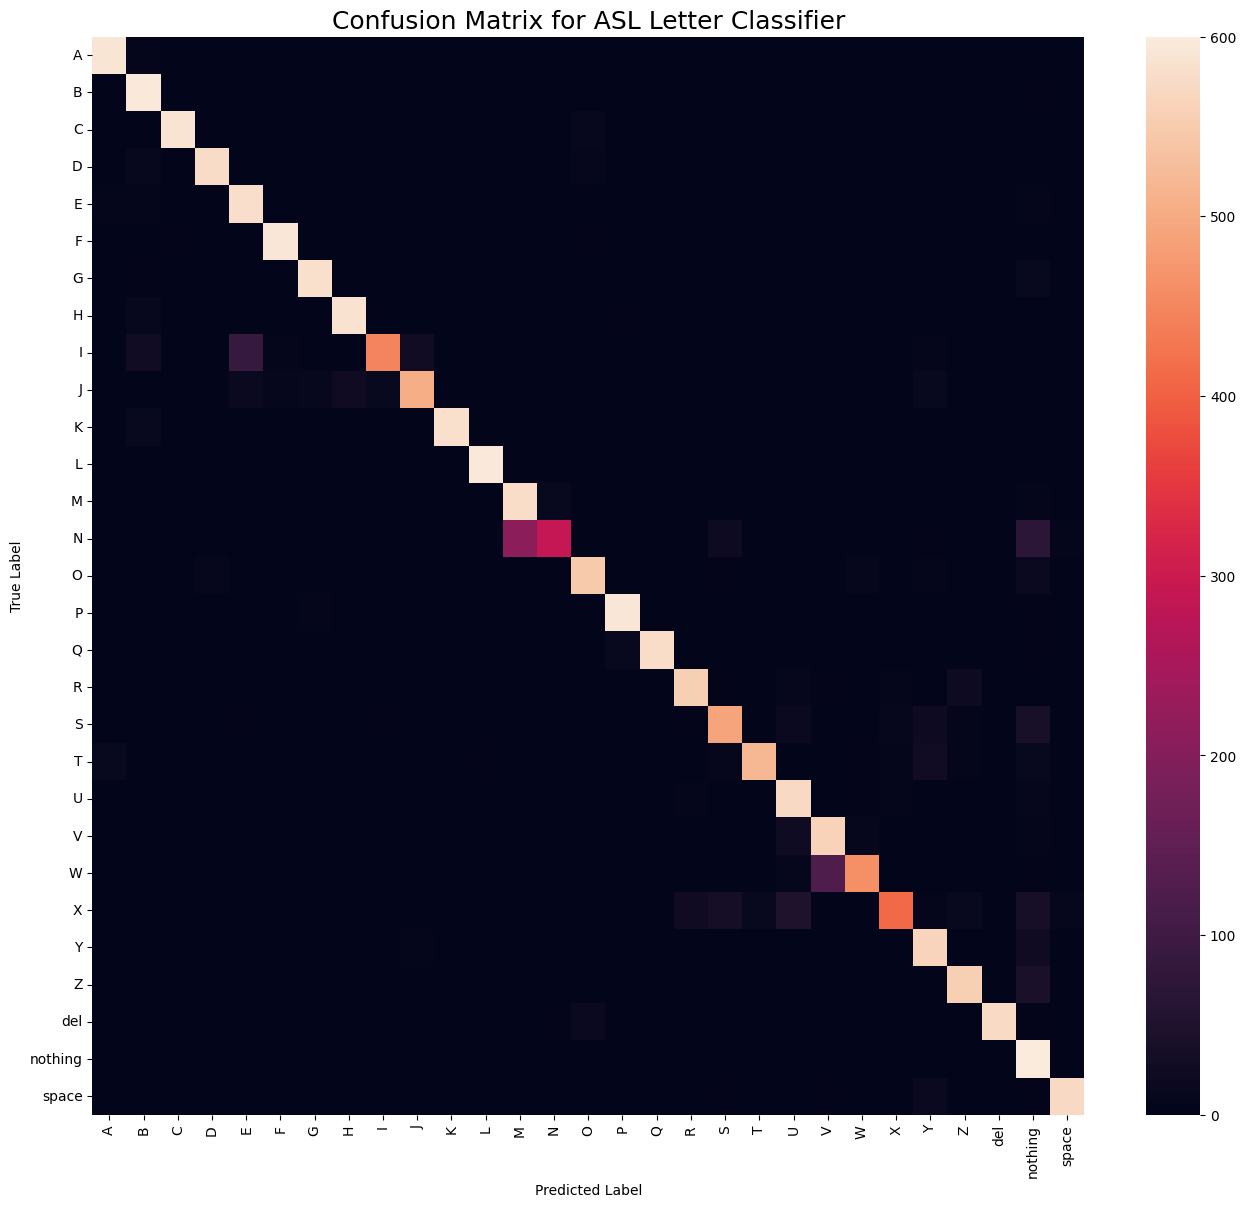

In [18]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for ASL Letter Classifier", fontsize=18)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [19]:
print("\n" + "="*60)
print("PER-CLASS ACCURACY (Letter Performance)")
print("="*60)

for idx, label in enumerate(class_labels):
    class_mask = (y_true == idx)
    accuracy = accuracy_score(y_true[class_mask], y_pred[class_mask])
    print(f"{label}: {accuracy:.4f}")


PER-CLASS ACCURACY (Letter Performance)
A: 0.9817
B: 0.9950
C: 0.9800
D: 0.9583
E: 0.9683
F: 0.9867
G: 0.9700
H: 0.9733
I: 0.7433
J: 0.8400
K: 0.9700
L: 0.9933
M: 0.9633
N: 0.4817
O: 0.9117
P: 0.9850
Q: 0.9617
R: 0.9233
S: 0.8183
T: 0.8650
U: 0.9500
V: 0.9350
W: 0.7683
X: 0.6867
Y: 0.9383
Z: 0.9250
del: 0.9533
nothing: 1.0000
space: 0.9500


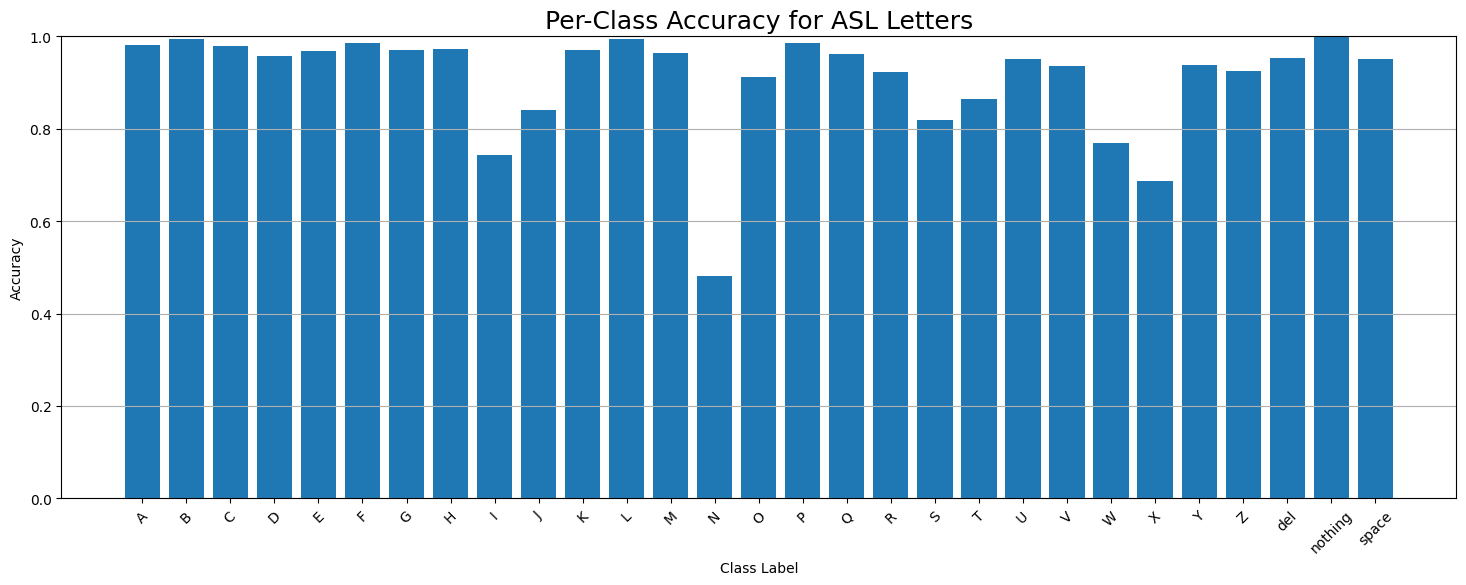

In [20]:
per_class_accuracy = []
for idx, label in enumerate(class_labels):
    mask = (y_true == idx)
    acc = accuracy_score(y_true[mask], y_pred[mask])
    per_class_accuracy.append(acc)

plt.figure(figsize=(18, 6))
plt.bar(class_labels, per_class_accuracy)
plt.xticks(rotation=45)
plt.title("Per-Class Accuracy for ASL Letters", fontsize=18)
plt.ylabel("Accuracy")
plt.xlabel("Class Label")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


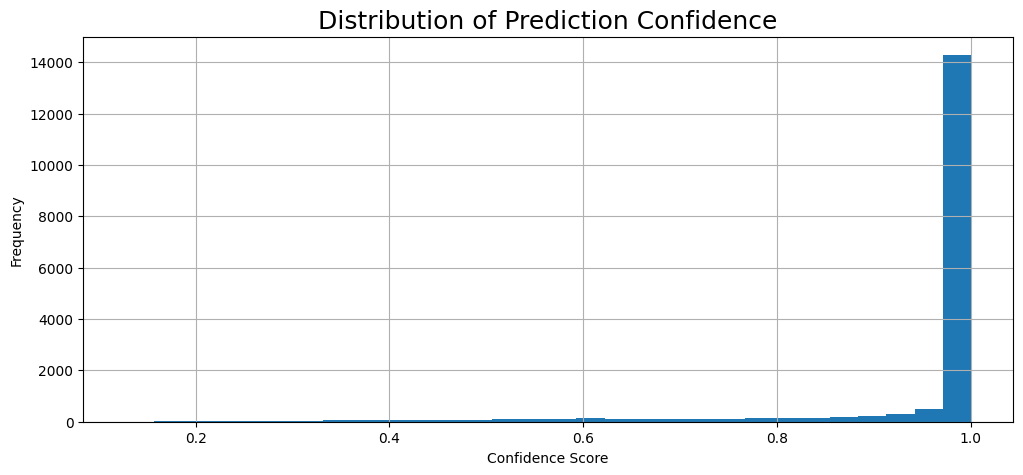

In [21]:
plt.figure(figsize=(12, 5))
plt.hist(confidences, bins=30)
plt.title("Distribution of Prediction Confidence", fontsize=18)
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## Predictions on new samples

* upload new image from anywhere you can capture this image by yourself and make test for model

In [29]:
img_path = "/kaggle/input/w-letter/testw.jpg"

# Load & preprocess
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = x / 255.0   
x = np.expand_dims(x, axis=0)

# Predict
pred = model.predict(x)[0]
predicted_class = np.argmax(pred)
confidence = np.max(pred)

# Extract labels from your train generator
labels = list(train_generator.class_indices.keys())
predicted_label = labels[predicted_class]

# True label (for testing)
true_label = "W"

# Print results
print(f"Predicted Letter: {predicted_label}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"True Label: {true_label}")

if predicted_label == true_label:
    print("Correct Prediction!")
else:
    print("Incorrect Prediction")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Letter: W
Confidence: 98.10%
True Label: W
Correct Prediction!
